# Chapter 6: Algorithm Chains and Pipelines

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import sklearn
import mglearn

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# calculate min and max on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the training scaled data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


## 1. Parameter Selection with Preprocessing

IMPROPER preprocessing:

In [54]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


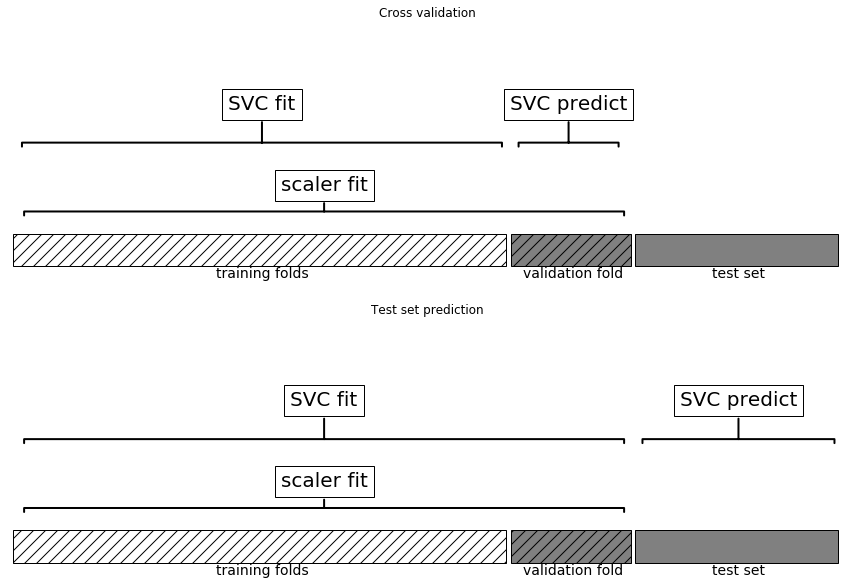

In [4]:
mglearn.plots.plot_improper_processing()

## 2. Building Pipelines

In [5]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [6]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [7]:
print("Test set accuracy: {:.2f}".format(pipe.score(X_test, y_test)))

Test set accuracy: 0.95


## 3. Using Pipelines in Grid-searches 

In [9]:
from sklearn.model_selection import GridSearchCV

In [11]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [12]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation occuracy: 0.98
Test set score: 0.97
Best parameters:  {'svm__C': 1, 'svm__gamma': 1}


PROPER preprocessing:

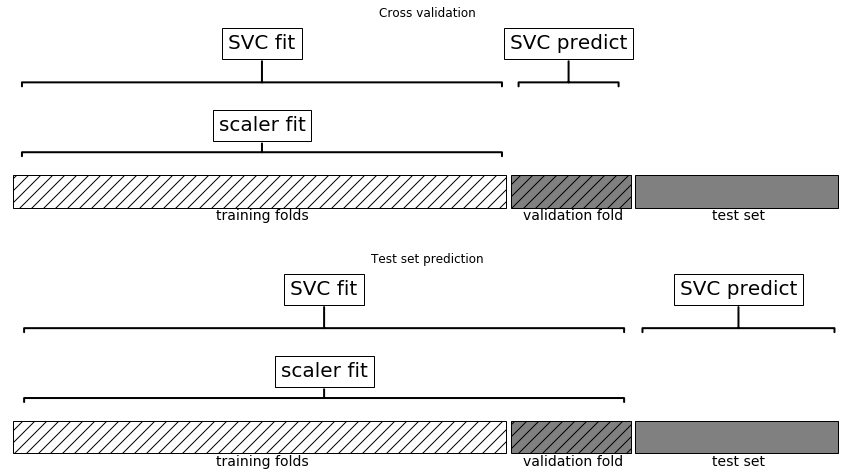

In [13]:
mglearn.plots.plot_proper_processing()

### 3.1 Information leak

In [14]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [16]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected shape: ", X_selected.shape)

X_selected shape:  (100, 500)


The following is a wrong case! We have absolutely independent X and y - our model shouldn't 'learn' anything, but it can...

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print("Cross-validation accuracy (cv on ridge only): {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation occuracy (cv on ridge only): 0.91


The following is a right realisation:

In [20]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


## 4. The General Pipeline Interface

In [21]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [22]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # predict using the last step
    return self.steps[-1][1].predict(X_transformed)

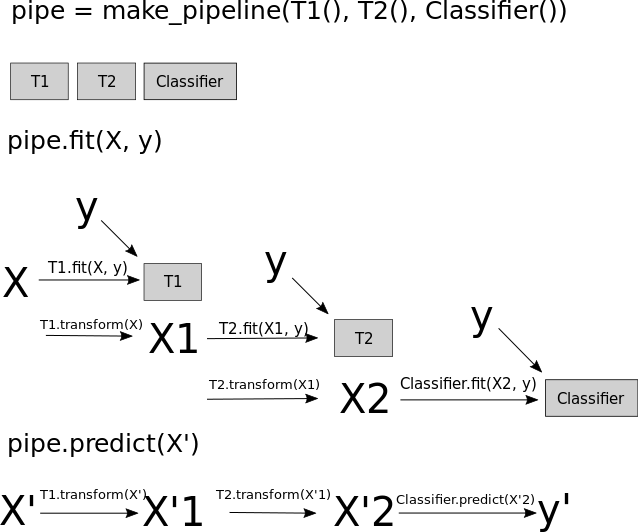

### 4.1 Convenient Pipeline creation with ```make_pipeline```

In [23]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [24]:
print("Pipeline steps:\n", pipe_short.steps)

Pipeline steps:
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n", pipe.steps)

Pipeline steps:
 [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


### 4.2 Accessing step attributes

In [26]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components
components = pipe.named_steps["pca"].components_
print("components.shape: ", components.shape)

components.shape:  (2, 30)


### 4.3 Accessing Attributes in a Pipeline inside GridSearchCV

In [27]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

We must use 'logisticregression' since make_pipeline generates this name for the second step

In [28]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [30]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
print("Best model:\n", grid.best_estimator_)

Best model:
 Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [32]:
print("Logistic regression step:\n", grid.best_estimator_.named_steps["logisticregression"])

Logistic regression step:
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [35]:
print("Logistic regression coefficients:\n", grid.best_estimator_.named_steps["logisticregression"].coef_)

Logistic regression coefficients:
 [[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


## 5. Grid-searching preprocessing steps and model parameters

In [36]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [37]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
grid.cv_results_['mean_test_score']

array([   0.72169353,    0.721697  ,    0.72173126,    0.7220378 ,
          0.72307143,    0.70772151,    0.73864353,    0.73756794,
          0.7441318 ,    0.77682137,    0.82103778,    0.80630064,
       -181.61396352,  -49.22387802,   -3.07615973,    0.27656439,
          0.63362711,    0.58780662])

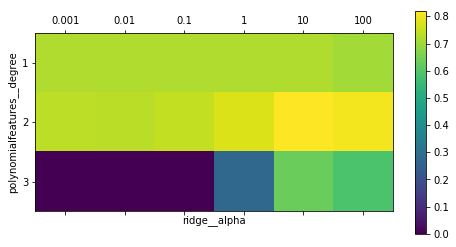

In [47]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap='viridis')
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])
plt.colorbar();

In [48]:
print("Best parameters: ", grid.best_params_)

Best parameters:  {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [49]:
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.77


To compare results run grid-search withoun polynomial transformation

In [50]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Accuracy without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Accuracy without poly features: 0.63


### 5.1 Best model selection with Grid-search

In [51]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [52]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
              'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'classifier': [RandomForestClassifier(n_estimators=100)],
               'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best parameters:\n{}\n".format(grid.best_params_))
print("Cross-validation best score: {:.2f}".format(grid.best_score_))
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Cross-validation best score: 0.99
Test score: 0.98
